## Finding Pairwise Correlations for DepMap (20Q2) Gene-Dependencies and Gene-Effects

In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import pearsonr
import networkx as nx

### Data Import

In [7]:
#dep = pd.read_csv("/home/annerer/Downloads/Achilles_gene_dependency.csv")

In [5]:
effect = pd.read_csv("/home/annerer/Dokumente/DepMap_Mining/Achilles_gene_effect.csv")

In [7]:
data = pd.read_csv("/home/annerer/Dokumente/DepMap_Mining/sample_info.csv")

In [ ]:
# result has columns: correlated gene pair / PCC-value
result = pd.read_feather('corr_effect_sorted.feather')

In [8]:
mapping = {}

for i in np.arange(0,data.shape[0],1):
    mapping[data.DepMap_ID[i]] = data.CCLE_Name[i]

effect["INDEX"] = effect.DepMap_ID
effect = effect.set_index('INDEX')
effect = effect.rename(index=mapping)

effect = effect.drop("DepMap_ID",1)

gene = effect.columns.to_list()
# split at space
for i in range(len(gene)):
    gene[i] = gene[i].split(" ") 

genes = []
for i in range(len(gene)):
    genes.append(gene[i][0])
    
effect.columns = genes

### New Vectorized Correlation Functions

In [154]:
def corr2_coeff(A, B):
    # Rowise mean of input arrays & subtract from input arrays 
    # themeselves
    A_mA = A - A.mean()
    B_mB = B - B.mean()

    # Sum of squares across rows
    ssA = (A_mA**2).sum()
    ssB = (B_mB**2).sum()

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA,ssB))

def vcorrcoef(X,y):
    Xm = X.mean()
    ym = y.mean()
    r_num = np.sum((X-Xm)*(y-ym))
    r_den = np.sqrt(np.sum((X-Xm)**2)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

#vcorrcoef(df['TP53 (7157)'],df["MDM2 (4193)"])

In [ ]:
correlations = {}
for col_a, col_b in itertools.combinations(effect, 2):
    correlations[col_a + '__' + col_b] = vcorrcoef(effect[col_a],
                                                   effect[col_b])

In [ ]:
result = pd.DataFrame.from_dict(correlations, orient='index')
pd.write_csv("effect_corr_pairs.csv",result)

potentially better version:

In [ ]:
# should not be needed, as the above version handles NaNs

correlations = {}
for col_a, col_b in itertools.combinations(effect, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    correlations[col_a + '__' + col_b] = vcorrcoef(effect[col_a][~nas],
                                                   effect[col_b][~nas])

Im web-interface von DepMap wird von Co-Dependencies gesprochen wenn
Korrelationen von Gene-Effect-Werten gemeint sind.

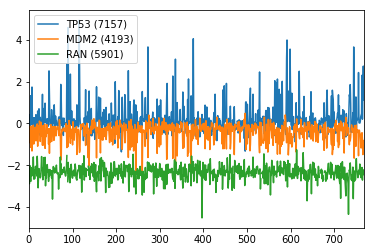

In [94]:
effect['RAN (5901)'].isnull().sum()
effect["TP53 (7157)"].plot()
effect["MDM2 (4193)"].plot()
effect["RAN (5901)"].plot()
plt.legend()
plt.savefig('comparrison_of_gene_effect_TP53_MDM2_RAN')

### Korrelationsskript

In [89]:
correlations = {}
df = effect[['MDM2 (4193)','TP53 (7157)']]

for col_a, col_b in itertools.combinations(df, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    corr = pearsonr(df[col_a][~nas], df[col_b][~nas])
    correlations[col_a + '__' + col_b] = corr

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']
result

In [155]:
df = effect
correlations = {}

for col_a, col_b in itertools.combinations(df, 2):
    corr = df[col_a].corr(df[col_b])
    correlations[col_a + '__' + col_b] = corr
result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC']
print('done')
result.to_csv('corr_effect_pairs_full.csv')

done


In [156]:
# new names that lend themselves to easier processing
result = pd.read_csv('corr_effect_pairs_full.csv')
result = result.rename(columns={'Unnamed: 0':'pairs','PCC':'PCC'})
result_sorted = result.sort_values('PCC')
result_sorted.to_csv('corr_effect_sorted.csv')

In [3]:
result = pd.read_csv('corr_effect_sorted.csv')
result.to_feather('corr_effect_sorted.feather')

In [ ]:
result = pd.read_feather('corr_effect_sorted.feather')

Data for Uli:

In [ ]:
top = result[result['PCC'] > 0.2]
bottom = result[result['PCC'] < -0.15]

top = top.drop('Unnamed: 0',1)
bottom = bottom.drop('Unnamed: 0',1)
len(bottom)
bottom.to_csv('bottom_pairwise_PCC_values.txt')
top.to_csv('top_pairwise_PCC_values.txt')

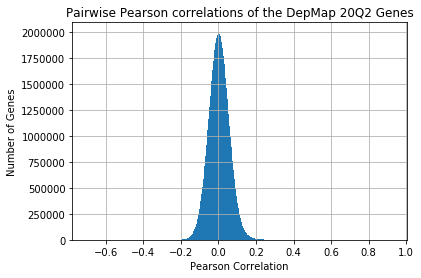

In [13]:
result_sorted['PCC'].hist(bins=1000)
plt.title("Pairwise Pearson correlations of the DepMap 20Q2 Genes")
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Genes")
plt.savefig('pairwise_pcc_geneEffects')

In [158]:
result_sorted.tail(5)

,pairs,PCC
128919440,SUPT20H__TADA2B,0.854789
84835691,TADA2B__TAF5L,0.866306
104388769,TADA1__TAF5L,0.875483
114130706,SUPT20H__TAF5L,0.889404
70640086,TSC1__TSC2,0.923451


In [159]:
result_sorted.head(5)

,pairs,PCC
162996,MDM2__TP53,-0.696747
93096746,MDM2__TP53BP1,-0.629534
40699436,PPM1D__TP53,-0.586922
63121155,ATM__MDM2,-0.533031
146694450,CHEK2__MDM2,-0.522001


In [161]:
a = result_sorted.head(20)['pairs'].to_list()
b = []

for _ in a:
    b.append(_.split("__"))

In [15]:
result = result.drop('Unnamed: 0',1)

In [8]:
list1 = []
print(result.shape)
#y = result.iloc[0]
result.head()
for _ in range(0,100):
    list1.append([result.iloc[_][0].split('__')[0],
                  result.iloc[_][0].split('__')[1],result.iloc[_][1]])

NameError: name 'result' is not defined

In [4]:
def celllines_from_diff(gene_a,gene_b):
    def diff(gene_a,gene_b):
        """ takes 2 genes and returns the cell lines
        for which those two genes have a high correlation
        or anticorrelation in gene effect"""
        diff = np.abs(effect[gene_a] - effect[gene_b])
        return (diff) 
    diff1 = diff(gene_a,gene_b)
    diff1_top = diff1.sort_values().tail(10).index.to_list()
    diff1_bottom = diff1.sort_values().head(10).index.to_list()
    print('first is top, second is bottom')
    plt.plot(diff1.sort_values())
    return([diff1_top,diff1_bottom])

def celllines_from_sums(gene_a,gene_b):
        def summ(gene_a,gene_b):
            summ = np.abs(effect[gene_a] + effect[gene_b])
            return summ
        summ1 = summ(gene_a,gene_b)
        summ1_top = summ1.sort_values().tail(10).index.to_list()
        summ1_bottom = summ1.sort_values().head(10).index.to_list()
        print('first is top, second is bottom')
        return([summ1_top,summ1_bottom])

In [1]:
#celllines_from_diff('NF2','AMOTL2')

In [17]:
celllines_from_sums("TP53",'MDM4')

first is top, second is bottom


[['GIMEN_AUTONOMIC_GANGLIA',
  'TTC549_SOFT_TISSUE',
  'RVH421_SKIN',
  'ICC3_BILIARY_TRACT',
  'BIN67_OVARY',
  'TUHR4TKB_KIDNEY',
  'TTC642_SOFT_TISSUE',
  'KMRC1_KIDNEY',
  'NMCG1_CENTRAL_NERVOUS_SYSTEM',
  'DKMG_CENTRAL_NERVOUS_SYSTEM'],
 ['SNU8_OVARY',
  'HS683_CENTRAL_NERVOUS_SYSTEM',
  'SNUC4_LARGE_INTESTINE',
  'GB1_CENTRAL_NERVOUS_SYSTEM',
  'HCC1806_BREAST',
  'NCIH2172_LUNG',
  'OVK18_OVARY',
  'MCF7_BREAST',
  'SUPT1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
  'HS766T_PANCREAS']]

In [176]:
#tissues_from_sums("CHEK2","PPM1D")[1]
#tissues_from_diff("CHEK2","PPM1D")

### Building a pairwise correlation network

In [2]:
data_graph = result_sorted[int(np.round(0.9999*length)):length]
strings = data_graph['pairs'].to_list()

a = []
for _ in strings:
    a.append(_.split(' '))

NameError: name 'result_sorted' is not defined

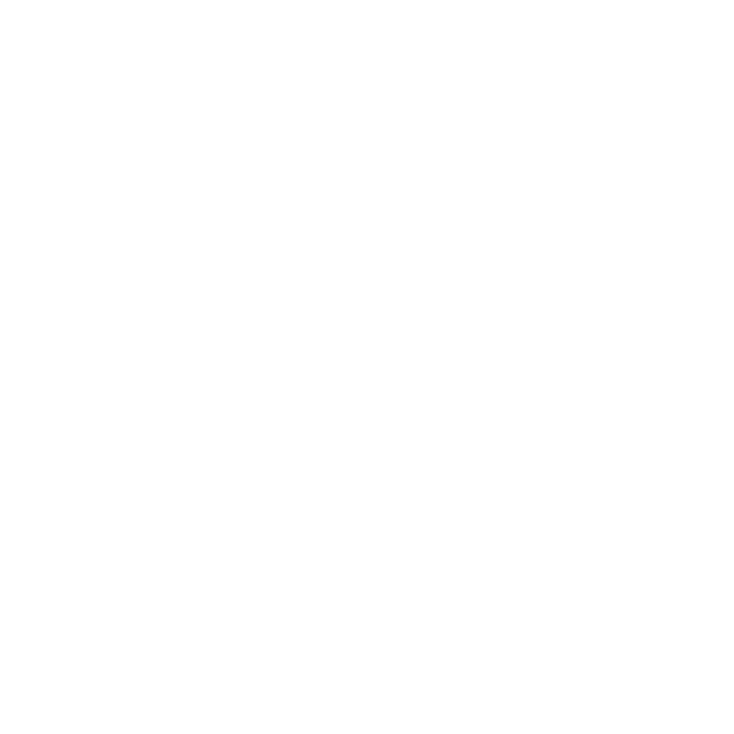

In [17]:
corr_data = list1
G=nx.Graph()
#result_sorted[int(np.round(0.99999*length)):length]
corr_data = [[x[0],x[1],1000**(x[2])] for x in corr_data]

'''
format of corr_data
corr_data =([['SUPT20H', 'TADA1', 0.85],
             ['TADA1', 'TADA2B', 0.83],
             ['SUPT20H', 'TAF5L', 0.889]]) '''

existing_edges = {}
def build_graph(w, lev):
    if (lev > 5)  :
        return
    for z in corr_data:
        ind=-1 
        if z[0] == w:
            ind=0
        ind1=1
    if z[1] == w:
         ind == 1
         ind1 = 0

    if ind == 0 or ind == 1:
        if  str(w) + "_" + str(corr_data[ind1]) not in existing_edges :

            G.add_node(str(corr_data[ind]))
            existing_edges[str(w) + "_" + str(corr_data[ind1])] = 1;
            G.add_edge(w,str(corr_data[ind1]))
            build_graph(corr_data[ind1], lev+1)

    existing_nodes = {}
def build_graph_for_all():
    count=0
    for d in corr_data:
        if (count > 40) :
              return
        if  d[0] not in existing_edges :
             G.add_node(str(d[0]))
        if  d[1] not in existing_edges :     
               G.add_node(str(d[1]))
        G.add_weighted_edges_from([[str(d[0]), str(d[1]),d[2]]])     
        count=count + 1

build_graph_for_all()
pos = nx.spring_layout(G)
nx.draw(G,pos=pos, width=2, with_labels=True)

plt.savefig("path2.png")
plt.rcParams["figure.figsize"] = (10,10)
#check why tp53 and mdm2 are not connected

In [22]:
#G.nodes #nx.closeness_centrality(G,'TP53')
degree_sequence = [G.degree(n) for n in G.nodes]
degree_sequence

[]

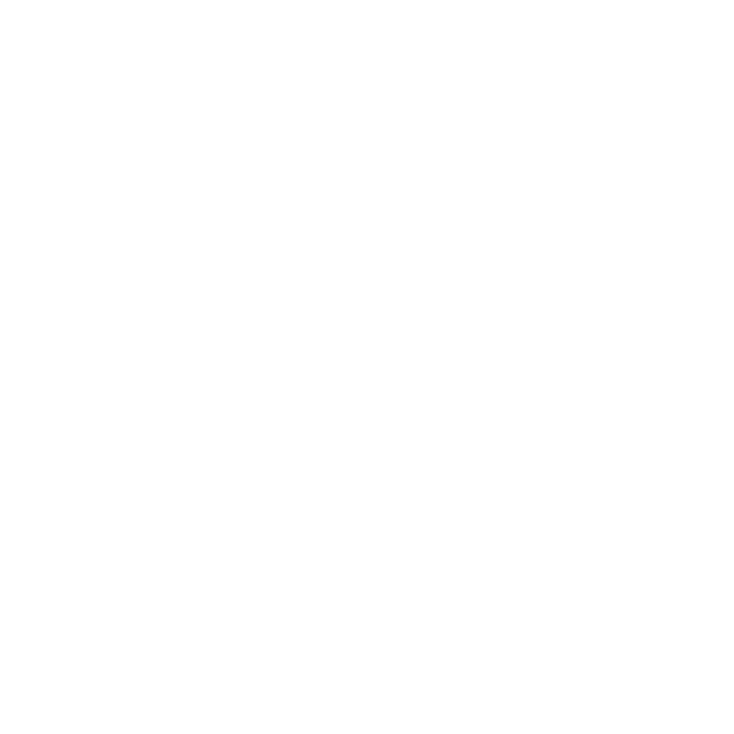

In [19]:
G=nx.Graph()
corr_data = [[x[0],x[1],1000**(x[2])] for x in corr_data]
existing_edges = {}
existing_nodes = {}
build_graph_for_all()
pos = nx.spring_layout(G,weight='weight')
nx.draw(G,pos=pos, width=2, with_labels=True)

plt.savefig("path3.png")

EMAIL AN JUERGEN

Hallo Jürgen,

Die Schneckenpost ist endlich da!
1) Meine Frage dreht sich darum wie du am besten paarweise korrelierte/antikorrelatierte Werte (eg a mit b) selektieren würdest, bzw wie du den entsprechenden Cutoff ansetzen würdest.

          a b ...
          ____ 
      c1 |_|_|
      c2 |_|_|
      c3 |_|_|
       .      .
       .        .
       .          .
        
    a,b...  genes 
    c_i ... conditions
    
 
Ich habe für den oben skizzierten Datensatz eine paarweise Pearsonkorrelation berechnet und für die jeweiligen conditions (c_i) den genetischen Hintergrund ermittelt. 
Uli meinte nun wir könnten für relevante Genpaare (aus der Korrelation) die Summe und Differenz der Geneffekte (Elemente aus obiger Matrix) pro Paar finden, um so auf die stark (anti-)korrelierten zu kommen.

Ziel ist es zu sehen ob bestimmte genetische Hintergründe in den {c_i} der stark (anti-)korrelierten enriched sind.

Es stellt sich auch die Frage ob ich den Cutoff im Vorhinein festlegen sollte. Uli meinte wir könnten die Differenz gegen die Zahl der Zellen (conditions) plotten und den initialen monoton fallenden Bereich nehmen.

Eine Frage wäre: Gibt es hier ein Standardverfahren?
Ich werde den Verdacht nicht los dass ich was offensichtliches übersehe.
Wie würdest du vorgehen? 
Habe das beschriebene Verfahren bereits implementiert, es geht
mir primär darum ob es auch 'sound' ist.

2) Bezüglich des Projekts:
Hättest du (MS) paper die ich lesen sollte um einen tieferen
einblick in die Materie zu bekommen?

3) Bezüglich Mathe:
Ich würde wirklich gern mithelfen, auch ohne Entlohnung.
Hab in der Vergangenheit viel Mathe-Nachhilfe gegeben und
hab damit gute Erfahrungen gemacht. Das war auch der Grund warum 
ich dich letzte Woche darauf angesprochen habe.

Beste Grüße,
Lukas

In [75]:
df = pd.DataFrame(np.random.random((6, 6)), columns=[chr(i + ord('a')) for i in range(6)]) 
df['a'][3] = np.nan
df['b'][4] = np.nan
print(df)

          a         b         c         d         e         f
0  0.238729  0.836833  0.844553  0.673913  0.478680  0.622733
1  0.442589  0.560388  0.344260  0.724260  0.231331  0.568334
2  0.851465  0.515215  0.464266  0.561362  0.071919  0.180770
3       NaN  0.812376  0.695367  0.309487  0.826105  0.817678
4  0.846068       NaN  0.156010  0.346022  0.740878  0.211795
5  0.679405  0.830221  0.057410  0.083349  0.570318  0.862084


In [78]:
nas = np.logical_or(np.isnan(df['a']), np.isnan(df['b']))
df['a'][~nas]

0    0.238729
1    0.442589
2    0.851465
5    0.679405
Name: a, dtype: float64

In [ ]:
correlations = {}

for col_a, col_b in itertools.combinations(df, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    corr = pearsonr(df[col_a][~nas], df[col_b][~nas])
    correlations[col_a + '__' + col_b] = corr

    
result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']
result.to_csv('effect_pairs.csv')

In [73]:
myarray = np.array([1,2,3,4,5,6,7,8,9,10])
zipped_array = zip(myarray[::2], myarray[1::2])
list(zipped_array)

[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]

### Pandas stellt die Importierten Daten nicht in ihrer vollen Laenge dar. Bei Berechnungen werden die 50+ Nachkommastellen jedoch verwendet

In [ ]:
#with pd.option_context('display.precision', 50):
#    print(dep['TP53 (7157)'].sort_values())

#### Wichtiges Snippet. Berechnung der Korrelation wobei ich keinen Wert nehme wenn einer der Partner NaN ist.

In [ ]:
#dep_corr = dep.corr()

for i in range(len(effect.columns)):    
    x, y = effect.iloc[ :,i].values,
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    corr = pearsonr(x[~nas], y[~nas])
    correlation.append(corr)

In [6]:
def get_conditions(df):
    # return row in which ga pairwise_correlation is higher than the average 
    result = df[(df.gene_a < df.gene_b) & (df.gene_a < df.gene_c) & (df.gene_a < df.gene_d)]
    return result.index.to_list()
    

In [20]:
data = pd.read_csv("/home/annerer/Downloads/sample_info.csv")

## Umbenennen der Zelllinien. 

siehe querrying depmap

In [21]:
mapping = {}

for i in np.arange(0,data.shape[0],1):
    mapping[data.DepMap_ID[i]] = data.CCLE_Name[i]

#mappign = data[['CCLE_Name','DepMap_ID']].to_dict()

In [121]:
dep = pd.read_csv("/home/annerer/Downloads/Achilles_gene_dependency.csv")

In [123]:
dep["new_index"] = dep.DepMap_ID
dep = dep.set_index('new_index')

In [124]:
dep = dep.rename(index=mapping)

password for phosphosite:

EfBGWYFFN8UtbAi

In [58]:
#df = pd.DataFrame(np.random.randn(10, 2), columns=list('ab'))
#df.query('a > b')

In [41]:
df = pd.DataFrame(np.random.random((6, 6)), columns=['gene_' + chr(i + ord('a')) for i in range(6)]) 
print(df)
df['gene_a'][3] = np.nan
df['gene_d'][4] = np.nan
df['gene_c'][2] = np.nan
df['gene_f'][1] = np.nan

     gene_a    gene_b    gene_c    gene_d    gene_e    gene_f
0  0.665301  0.869902  0.879890  0.169911  0.608579  0.341876
1  0.277930  0.497177  0.199557  0.956748  0.328038  0.248854
2  0.438563  0.367788  0.437718  0.481967  0.745440  0.861007
3  0.878028  0.214308  0.532944  0.560893  0.383670  0.271503
4  0.725735  0.719277  0.773572  0.248921  0.191922  0.422448
5  0.032156  0.146041  0.829202  0.918093  0.877938  0.340987


In [59]:
# !!!
correlations = {}

for col_a, col_b in itertools.combinations(df, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    corr = pearsonr(df[col_a][~nas], df[col_b][~nas])
    correlations[col_a + '__' + col_b] = corr
# !!!

## Pairwise Gene Correlations DepMap 20Q2

In [41]:
data = pd.read_csv('/home/annerer/Downloads/elife-58925-supp2-v3.txt')

In [45]:
data = data["DMKN"].to_list()

In [7]:
# using sets to compare the lists
'''
list1 = genes
list2 = data
intersection_set = set.intersection(set(list1), set(list2))
# find intersection of list1 and list2
intersection_list = list(intersection_set)
print(intersection_list)
'''

'\n\nlist1 = genes\n\nlist2 = data\n\nintersection_set = set.intersection(set(list1), set(list2))\n\n# find intersection of list1 and list2\n\nintersection_list = list(intersection_set)\n\nprint(intersection_list)\nprint(len(intersection_list))\nprint(len(data))\n'

## Querrying the Co-Dependencies for the Cell Lines they occur in

fuer eine etwaige suche wuerde ich in Pandas die Indexe, die ich 
in Zelllinien-Namen umbenannt habe ausgebe fuer Paare in denen die Co-Dependency hoch ist. 
Dh ich habe eine Matrix. Gegeben ein Wert in einer Spalte ist hoch - gib den Index (die Zelllinie) aus. Wenn ein Wert in einer Spalte einer Co-Dependency entspricht sollte es so funktionieren.

### If this is done, the results could be checked against the genome to find if it is an oncogene addiction or not.

which files do we need for the genomes?
how do we best display them?


In [10]:
ulidata = pd.read_csv("/home/annerer/Downloads/TP53_MDM4.csv")
ulidata = ulidata['cellline'].to_list()

result = []

for _ in ulidata:
    result.append(mapping[_])
    
cellLine = result
# split at space
for i in range(len(cellLine)):
    cellLine[i] = cellLine[i].split("_") 

cell_L = []
for i in range(len(cellLine)):
    cell_L.append(cellLine[i][0])

In [27]:
ulidata = ulidata['cellline'].to_list()

In [28]:
result = []
for _ in ulidata:
    result.append(mapping[_])

In [41]:
cellLine = result
# split at space
for i in range(len(cellLine)):
    cellLine[i] = cellLine[i].split("_") 

cellLines3 = []
for i in range(len(cellLine)):
    cellLines3.append(cellLine[i][0])

AttributeError: 'list' object has no attribute 'split'

In [45]:
new_ceL = cellLines

## Finding the top correlations

In [ ]:
def find_correlates(gene_a,gene_b):
""" takes 2 genes and returns the cell lines
for which those two genes have a high correlation
or anticorrelation in gene effect"""

    for cola,colb in enumerate(df,2):
        diff = np.abs(cola - colb)
        summ = np.abs(cola - colb)
    

CDK4	RB1	-0.270088658037034	AB
CDK4	CDKN2C	-0.332894420570415	AB
CDK4	CCND1	0.383743671693837	BA
CDK6	CCND3	0.429610217617713	BA
CDK6	CCNE1	-0.291627386055655	BA
CDK6	CDK4	-0.166138251188281	BA
CDKN2A	CDKN2B	0.252271039837043	AB
CDKN2A	CCNE1	-0.164517699579397	BA

--------------------------------

NF2	AMOTL2	0.604088180582646	BA
NF2	KIRREL1	0.557319887509312	BA
NF2	TAOK1	0.537086753404031	AB
NF2	LATS2	0.522628225045063	BA
NF2	PTPN14	0.426594811534134	AB
NF2	PTEN	0.280261686290702	AB
NF2	ABL2	0.251003837455685	BA
NF2	RAC1	-0.345269416089392	AB
NF2	CRK	-0.404878434040191	BA
NF2	DLG5	-0.405139954747337	BA
NF2	PKN2	-0.445751736055664	AB

In [4]:
data = pd.read_csv("/home/annerer/Dokumente/DepMap_Mining/sample_info.csv")


In [6]:
data.columns.to_list()

['DepMap_ID',
 'stripped_cell_line_name',
 'CCLE_Name',
 'Alias',
 'COSMICID',
 'sex',
 'source',
 'Achilles_n_replicates',
 'cell_line_NNMD',
 'culture_type',
 'culture_medium',
 'cas9_activity',
 'RRID',
 'sample_collection_site',
 'primary_or_metastasis',
 'primary_disease',
 'Subtype',
 'age',
 'Sanger_Model_ID',
 'depmap_public_comments',
 'lineage',
 'lineage_subtype',
 'lineage_sub_subtype',
 'lineage_molecular_subtype']

In [9]:
data['primary_disease'].head(30)

0              Ovarian Cancer
1                    Leukemia
2     Colon/Colorectal Cancer
3                    Leukemia
4                    Leukemia
5                    Leukemia
6     Colon/Colorectal Cancer
7                 Skin Cancer
8     Colon/Colorectal Cancer
9                 Lung Cancer
10             Bladder Cancer
11                Lung Cancer
12             Ovarian Cancer
13                Skin Cancer
14                Lung Cancer
15              Kidney Cancer
16              Breast Cancer
17             Bladder Cancer
18              Breast Cancer
19                   Leukemia
20                Lung Cancer
21          Pancreatic Cancer
22          Pancreatic Cancer
23                    Myeloma
24               Brain Cancer
25             Bladder Cancer
26               Brain Cancer
27              Breast Cancer
28                Lung Cancer
29                Lung Cancer
Name: primary_disease, dtype: object

In [10]:
data['Subtype'].head(30)

0                     Adenocarcinoma, high grade serous
1     Acute Myelogenous Leukemia (AML), M3 (Promyelo...
2                                        Adenocarcinoma
3     Acute Myelogenous Leukemia (AML), M6 (Erythrol...
4     Acute Myelogenous Leukemia (AML), M6 (Erythrol...
5     Acute Myelogenous Leukemia (AML), M5 (Eosinoph...
6                                        Adenocarcinoma
7                                              Melanoma
8                                        Adenocarcinoma
9     Non-Small Cell Lung Cancer (NSCLC), Adenocarci...
10                                            Carcinoma
11    Non-Small Cell Lung Cancer (NSCLC), Adenocarci...
12                    Adenocarcinoma, high grade serous
13                                             Melanoma
14    Non-Small Cell Lung Cancer (NSCLC), Large Cell...
15                                 Renal Cell Carcinoma
16                                            Carcinoma
17                                            Ca

In [ ]:
def counting_phenotypes(top1,mut):
    top1_count = []
    for _ in top1:
        top1_count.append(data[data['CCLE_Name'].str.match(_)].eval(mut).to_list())
    
    top1_count = [i for j in top1_count for i in j]
    top1_count = sum(top1_count)
    
    return(top1_count)

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 12
Average degree:   2.1818


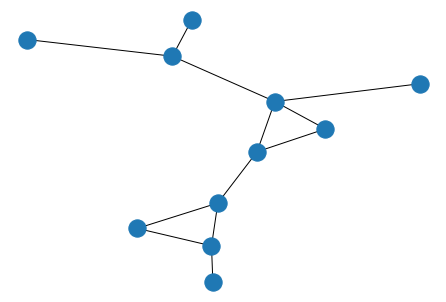

In [2]:

import networkx as nx
G = nx.read_edgelist('/home/annerer/Dokumente/DepMap_Mining/test_netzwerk.txt')
print(nx.info(G))
nx.draw(G)

In [54]:
degree_sequence = [G.degree(n) for n in G.nodes]
degree_sequence

[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 1]

In [28]:
from collections import Counter

degree_counts = Counter(degree_sequence)
degree_counts

Counter({3: 4, 2: 2, 1: 4, 4: 1})

In [30]:
min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())

plot_x = list(range(min_degree, max_degree + 1))

In [42]:
plot_y = [degree_counts.get(x, 0) for x in plot_x]
plot_y2 = [x/sum(plot_y) for x in plot_y ]

Text(0.5, 1.0, 'degree distribution')

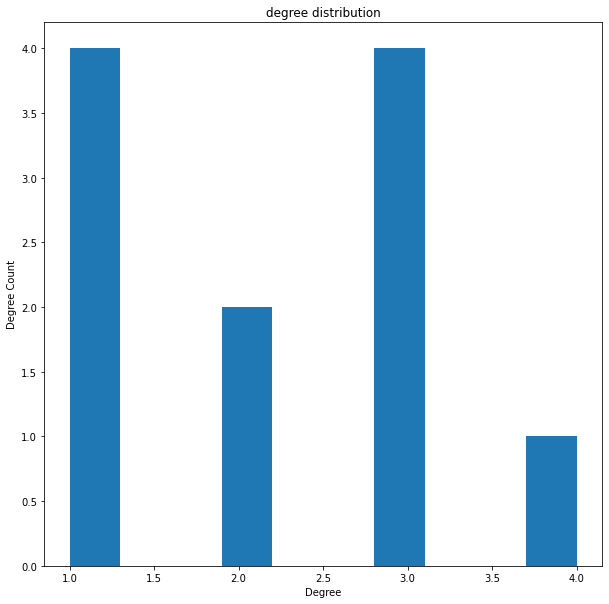

In [55]:

counts, bins, patches = plt.hist(degree_sequence, bins=10)

plt.xlabel('Degree')
plt.ylabel('Degree Count')
plt.title('degree distribution')

In [3]:
nx.degree_assortativity_coefficient(G)

-0.40624999999999933